In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import distinctipy as dpy
import colormaps as cmaps

from tqdm import tqdm
from sklearn.cluster import DBSCAN


In [41]:
dfs = {
    "250" : pd.read_csv("./tsne_alivhep_k250_test.csv"),
    "500" : pd.read_csv("./tsne_alivhep_k500_test.csv"),
    "1000" : pd.read_csv("./tsne_alivhep_k1000_test.csv"),
    "2500" : pd.read_csv("./tsne_alivhep_k2500_test.csv"),
    "5000" : pd.read_csv("./tsne_alivhep_k5000_test.csv"),
}

for name, df in dfs.items():
    df["k"] = int(name)

df_full = pd.concat(dfs.values(), ignore_index=True)

n_dfs = len(dfs)
tcolumns = columns = ["tsne0", "tsne1"]

df_full

,tsne0,tsne1,label,file_n,k
0,-58.040337,26.724573,liver_hepatocytes,0,250
1,-8.168453,52.317833,liver_hepatocytes,0,250
2,106.353320,-7.135744,liver_hepatocytes,0,250
3,22.392519,79.837610,liver_hepatocytes,0,250
4,-93.239940,-27.382153,liver_hepatocytes,0,250
...,...,...,...,...,...
39681,-4.579841,-16.654936,liver_hepatocytes,15,5000
39682,24.969082,-22.768260,liver_hepatocytes,15,5000
39683,-35.949875,-79.003150,liver_hepatocytes,15,5000
39684,30.107594,26.482882,liver_hepatocytes,15,5000


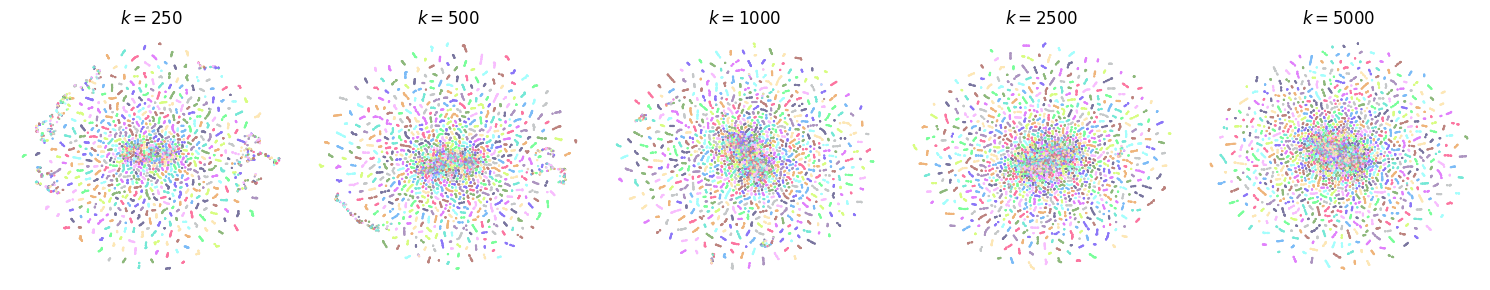

In [42]:
fig, axs = plt.subplots(1, n_dfs, figsize=(15,3))

run_colors = np.array( dpy.get_colors(df_full['file_n'].nunique(), pastel_factor=0.8))

def plot_tsnes(df : pd.DataFrame, ax, name):
    colors = run_colors[df["file_n"].values]

    ax.scatter(df[tcolumns[0]], df[tcolumns[1]], s=0.3, c=colors)
    ax.set_title(f"$k={name}$")

    ax.axis('off')

for (name, df), ax in zip(dfs.items(), axs):
    plot_tsnes(df, ax, name)


fig.tight_layout()
fig.savefig("tsne_run_colors.png", dpi=800)

In [78]:
def dbscan_cluster(df, columns, eps, min_samples):
    X = df[columns].values
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    clustering = clustering.labels_

    max_i = max(clustering)

    for i, c in enumerate(clustering):
        if c == -1:
            max_i += 1
            clustering[i] = max_i

    return clustering

def get_clusterings(columns, eps , min_samples) -> dict[str, list[int]]:
    clusterings = {
        name : dbscan_cluster(dfs[name], columns, eps, min_samples)
        for name in dfs.keys()
    }

    return clusterings

def get_clusterings_ns(clusterings) -> dict[str,int]:
    clusterings_ns = {
        name : len(set(clusterings[name]))
        for name in tqdm(dfs.keys(), desc="Counting")
    }

    return clusterings_ns

epss = np.arange(1, 3.5, 0.25)

clusterings = get_clusterings(tcolumns, 2, 5)            
clusterings_ns = get_clusterings_ns(clusterings)

clusterings_ns_by_eps = [
    (eps, list(get_clusterings_ns(get_clusterings(tcolumns, eps, 5)).values()))
    for eps in epss
]

cluster_colors = dpy.get_colors(10, pastel_factor=0.8)
cluster_colors = cluster_colors * (max(clusterings_ns.values()) // 10 + 1)

Counting: 100%|██████████| 5/5 [00:00<00:00, 2544.78it/s]


Plotting: 5it [00:00, 228.38it/s]


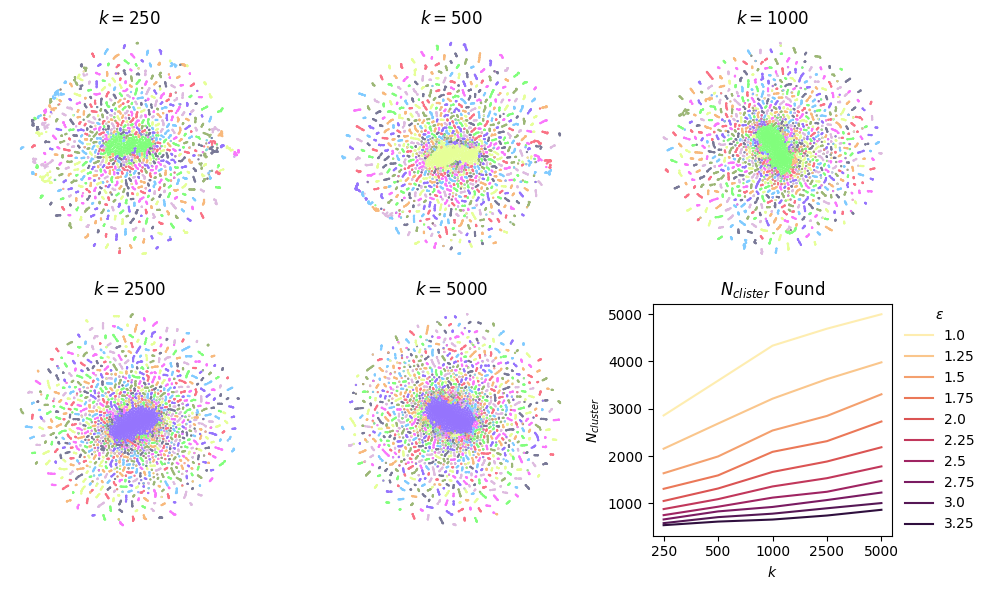

In [87]:

def plot_tsne_clustering(df, ax, name):
    columns = ["tsne0", "tsne1"]
    
    clustering = clusterings[name]
    c = np.array(cluster_colors)[clustering]
    
    ax.scatter(df[columns[0]], df[columns[1]], c=c, s=0.3)
    ax.set_title(f"$k={name}$")

    ax.axis('off')

fig, axs = plt.subplots(2, 3, figsize=(10, 6))

axs = list(axs[0]) + list(axs[1])

for (name, df), ax in tqdm(zip(dfs.items(), axs), desc="Plotting"):
    plot_tsne_clustering(df, ax, name)

ns_colors = cmaps.matter.discrete(len(epss)).colors

for i, (eps, ns) in enumerate(clusterings_ns_by_eps):
    axs[-1].plot(ns, label=eps, c=ns_colors[i])
    axs[-1].set_xticks(list(range(len(clusterings))), clusterings.keys())

axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='$\epsilon$')
axs[-1].set_title("$N_{clister}$ Found")
axs[-1].set_xlabel("$k$")
axs[-1].set_ylabel("$N_{cluster}$")

fig.tight_layout()
plt.savefig("tsne_dbscan.png", dpi=400)